In [476]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nqDataLoader as nq #data loading library

In [477]:
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score
from sklearn.model_selection import cross_val_score
def testClassifier(classifier,X_train,X_test,y_train,y_test):
    classifier.fit(X_train,y_train)
    y_pred =  classifier.predict(X_test)
    titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            display_labels=None ,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()
    print("Accuracy score : " + str(accuracy_score(y_test, y_pred,  normalize=True, sample_weight=None)))
    X = np.concatenate((X_train, X_test), axis=0) 
    y = np.concatenate((y_train, y_test), axis=0)
    scores = cross_val_score(classifier,X,y,cv=30)
    print("Mean accuracy of 30 fold cross validation test : "+ str(scores.mean()))
    print("with a maximum accuracy of " + str(scores.max()))

## importing the early_stage data set 

In [478]:
## importing the early stage dataset 
early_stage = pd.read_csv('GT_DataPD_MIT-CS2PD.csv')
# X = dataset.iloc[:, :-1].values
# y = dataset.iloc[:, -1].values
early_stage.head()

,pID,gt,updrs108,afTap,sTap,nqScore,typingSpeed,file_1
0,1000,True,27,79.0,184.5,0.107179,56.866667,1424946827.1000_001_014.csv
1,1001,True,16,96.5,189.0,0.056286,118.000000,1427279751.1001_001_014.csv
2,1002,False,5,140.0,158.0,0.039519,119.037037,1426676689.1002_001_014.csv
3,1004,True,22,83.5,191.5,0.034853,74.266667,1429866367.1004_001_014.csv
4,1005,True,17,68.0,150.0,0.048307,74.969697,1430134526.1005_001_014.csv


## Calculating the SDI for early stage dataset 

In [479]:
def is_outlier(value, p25, p75):
    """Check if value is an outlier
    """
    lower = p25 - 1.5 * (p75 - p25)
    upper = p75 + 1.5 * (p75 - p25)
    return value <= lower or value >= upper

In [480]:
SD_index = []
outlier_count = []
for index, row in early_stage.iterrows():
    fileloc = row.file_1
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( "data_MIT-CS2PD/" + early_stage.loc[index]['file_1'])
    fluctuations = []
    for i in range(0,len(htArr)-1):
        row1 = htArr[i]
        row2 = htArr[i+1]
        temp1 = np.log(row1)
        temp2 = np.log(row2)
        result = temp2-temp1
        fluctuations.append(result)
    npFluctuations = np.array(fluctuations)
    ## getting outlier count 
    nphtArr = np.array(htArr)
    outliers = []
    p25 = np.percentile(nphtArr, 25)
    p75 = np.percentile(nphtArr, 75)
    for ind, value in enumerate(nphtArr):
        if is_outlier(value, p25, p75):
            outliers.append(value) 
    
    sd_index_score = npFluctuations.std()
    SD_index.append(sd_index_score)
    npoutliers = np.array(outliers)
    outlier_count.append(npoutliers.std())
    
    
early_stage["SDi"] = SD_index
early_stage['htArrOutliers'] = outlier_count

In [481]:
from scipy.stats import skew
TypingSkew =[]
for index, row in early_stage.iterrows():
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS2PD/' + early_stage.loc[index]['file_1'])
    skew1 = skew(htArr)
    TypingSkew.append(skew1)
   
    
    

early_stage['TypingSkew'] =TypingSkew

In [482]:
dexterityMetric = []
for index, row in early_stage.iterrows():
    fileloc1 = row.file_1
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS2PD/' + early_stage.loc[index]['file_1'])
    
    dexterity = []
    for i in range(0,len(keyPressed)-1):
        d1 = releaseArr[i]
        p2 = pressArr[i+1]
        result = 0 if (d1-p2 < 0) else (d1-p2)
        dexterity.append(result)
    npdexterity = np.array(dexterity)
    dexterityMetric.append(npdexterity.std())
    

early_stage["Dexterity"] = dexterityMetric

## preparing the dataset to only have SDi as a feature and the gt as the dependant variable

In [483]:
early_stage["gt"] = early_stage["gt"].astype(int)

early_stage.drop(["pID",'updrs108','afTap','sTap','nqScore','typingSpeed','file_1'], axis=1, inplace=True)
early_stage = early_stage[['SDi','TypingSkew','Dexterity','htArrOutliers','gt']]
print(len(early_stage))
early_stage.head


54


<bound method NDFrame.head of          SDi  TypingSkew  Dexterity  htArrOutliers  gt
0   0.380584    8.366899   0.001368       0.232053   1
1   0.378429    3.633781   0.021848       0.095549   1
2   0.349012    3.924409   0.000713       0.040351   0
3   0.354817    0.901742   0.000000       0.048479   1
4   0.236304    0.843820   0.001078       0.040148   1
5   0.430976    1.656628   0.006776       0.021711   1
6   0.585704    1.025214   0.012554       0.014129   1
7   0.366079    0.735420   0.006436       0.106657   1
8   0.296538    0.907131   0.009804       0.035505   0
9   0.321620    0.791279   0.006682       0.053050   0
10  0.269081    0.964474   0.000252       0.029937   0
11  0.328355   20.828231   0.017663       0.231070   0
12  0.566683    2.285284   0.024966       0.123105   1
13  0.251682    1.643379   0.000000       0.049625   0
14  0.431035    1.106798   0.005423       0.012650   0
15  0.346295    0.611531   0.000000       0.134855   1
16  0.483142    0.995571   0.013287

## importing the de_novo dataset

In [484]:
## importing the de-novo dataset 
de_novo = pd.read_csv('GT_DataPD_MIT-CS1PD.csv')
# X = dataset.iloc[:, :-1].values
# y = dataset.iloc[:, -1].values
print(len(de_novo))
de_novo.head()

31


,pID,gt,updrs108,afTap,sTap,nqScore,typingSpeed,file_1,file_2
0,11,True,14.25,NaN,162.25,0.117543,189.372549,1402930351.011_001_014.csv,1403706430.011_003_014.csv
1,60,False,2.00,NaN,162.25,0.070350,60.533333,1402932300.060_001_014.csv,1403708258.060_003_014.csv
2,67,True,25.25,NaN,133.75,0.223411,54.333333,1401117235.067_001_014.csv,1401978395.067_003_014.csv
3,68,False,6.00,NaN,159.00,0.074973,71.800000,1401114972.068_001_014.csv,1401980765.068_003_014.csv
4,70,True,26.25,NaN,113.50,0.175751,39.614035,1404311419.070_001_014.csv,1404743687.070_003_014.csv


## calculating the SDi for the de_novo dataset 

In [485]:
##using both files 
SD_index = []
outlier_count = []
for index, row in de_novo.iterrows():
    fileloc1 = row.file_1
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_1'])
    nphtArr = np.array(htArr)
    ##fiinding outliers
    outliers = []
    p25 = np.percentile(nphtArr, 25)
    p75 = np.percentile(nphtArr, 75)
    for ind, value in enumerate(nphtArr):
        if is_outlier(value, p25, p75):
            outliers.append(value) 
    fluctuations = []
    for i in range(0,len(htArr)-1):
        row1 = htArr[i]
        row2 = htArr[i+1]
        temp1 = np.log(row1)
        temp2 = np.log(row2)
        result = temp2-temp1
        fluctuations.append(result)
    
    fileloc2 = row.file_2
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_2'])
    nphtArr = np.array(htArr)
    p25 = np.percentile(nphtArr, 25)
    p75 = np.percentile(nphtArr, 75)
    for ind, value in enumerate(nphtArr):
        if is_outlier(value, p25, p75):
            outliers.append(value) 
    for i in range(0,len(htArr)-1):
        row1 = htArr[i]
        row2 = htArr[i+1]
        temp1 = np.log(row1)
        temp2 = np.log(row2)
        result = temp2-temp1
        fluctuations.append(result)  
    npFluctuations = np.array(fluctuations)
    sd_index_score = npFluctuations.std()
    SD_index.append(sd_index_score)
    npoutliers = np.array(outliers)
    outlier_count.append(npoutliers.std())
    
de_novo["SDi"] = SD_index
de_novo['htArrOutliers'] = outlier_count
de_novo.head()

C:\Python310\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Python310\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Python310\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,pID,gt,updrs108,afTap,sTap,nqScore,typingSpeed,file_1,file_2,SDi,htArrOutliers
0,11,True,14.25,NaN,162.25,0.117543,189.372549,1402930351.011_001_014.csv,1403706430.011_003_014.csv,0.564521,0.114139
1,60,False,2.00,NaN,162.25,0.070350,60.533333,1402932300.060_001_014.csv,1403708258.060_003_014.csv,0.421491,0.102949
2,67,True,25.25,NaN,133.75,0.223411,54.333333,1401117235.067_001_014.csv,1401978395.067_003_014.csv,0.448163,0.032978
3,68,False,6.00,NaN,159.00,0.074973,71.800000,1401114972.068_001_014.csv,1401980765.068_003_014.csv,0.229087,0.019914
4,70,True,26.25,NaN,113.50,0.175751,39.614035,1404311419.070_001_014.csv,1404743687.070_003_014.csv,0.319824,0.089441


In [486]:
dexterityMetric = []
for index, row in de_novo.iterrows():
    fileloc1 = row.file_1
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_1'])
    
    dexterity = []
    for i in range(0,len(keyPressed)-1):
        d1 = releaseArr[i]
        p2 = pressArr[i+1]
        result = 0 if (d1-p2 < 0) else (d1-p2)
        dexterity.append(result)
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_2'])
    htArrFirst = htArr[0]
    fluctuations.append(result)
    for i in range(1,len(keyPressed)-1):
        d1 = releaseArr[i]
        p2 = pressArr[i+1]
        result = 0 if (d1-p2 < 0) else (d1-p2)
        dexterity.append(result)
    npdexterity = np.array(dexterity)
    dexterityMetric.append(npdexterity.std())
    

de_novo["Dexterity"] = dexterityMetric

In [487]:
from scipy.stats import skew
TypingSkew =[]
for index, row in de_novo.iterrows():
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_1'])
    skew1 = skew(htArr)
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_2'])
    skew2 = skew(htArr)
    TypingSkew.append((skew1+skew2)/2.0)
   
    
    

de_novo['TypingSkew'] =TypingSkew

## trimming the de_novo dataset to contain only the SDi as a feature and the gt as the target variable 

In [488]:
de_novo["gt"] = de_novo["gt"].astype(int)

# de_novo.drop(["pID",'updrs108','afTap','sTap','nqScore','typingSpeed','file_1','file_2'], axis=1, inplace=True)
de_novo = de_novo[['SDi','TypingSkew','Dexterity','htArrOutliers','gt']]
de_novo.head()

,SDi,TypingSkew,Dexterity,htArrOutliers,gt
0,0.564521,4.721638,0.012277,0.114139,1
1,0.421491,2.103442,0.001475,0.102949,0
2,0.448163,0.905364,0.002181,0.032978,1
3,0.229087,0.586957,0.000000,0.019914,0
4,0.319824,0.608208,0.000000,0.089441,1


## splitting the de_novo patients to double the dataset size by considering file_2 of a patient a different 

## appending the datasets together

54
31
85
(4, 4)


C:\Users\micoa\AppData\Local\Temp\ipykernel_11468\3982643381.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["gt"] =list(map(lambda x : 1 if x == True else 0 , dataframe["gt"]))
C:\Users\micoa\AppData\Local\Temp\ipykernel_11468\3982643381.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[['SDi','TypingSkew','Dexterity']] = sc.fit_transform(dataframe.iloc[:,:-1])


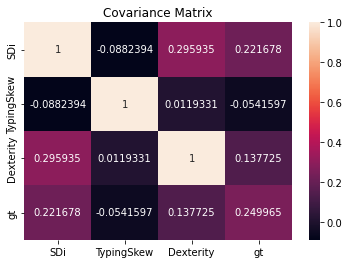

In [489]:
print(len(early_stage))
print(len(de_novo))
early_stage = pd.concat([early_stage,de_novo])
print(len(early_stage))
import seaborn as sns
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
dataframe = early_stage[['SDi','TypingSkew','Dexterity','gt']]
dataframe["gt"] =list(map(lambda x : 1 if x == True else 0 , dataframe["gt"]))
dataframe[['SDi','TypingSkew','Dexterity']] = sc.fit_transform(dataframe.iloc[:,:-1])
cov = np.cov(dataframe.T, bias=True)
labs = ['SDi', 'TypingSkew', 'Dexterity','gt']
sns.heatmap(cov, annot=True, fmt='g', xticklabels=labs, yticklabels=labs)
plt.title("Covariance Matrix")
print(np.shape(cov))



85
31
116


C:\Users\micoa\AppData\Local\Temp\ipykernel_11468\284066489.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["gt"] =list(map(lambda x : 1 if x == True else 0 , dataframe["gt"]))


(4, 4)


C:\Users\micoa\AppData\Local\Temp\ipykernel_11468\284066489.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[['SDi','TypingSkew','Dexterity']] = sc.fit_transform(dataframe.iloc[:,:-1])
C:\Users\micoa\AppData\Local\Temp\ipykernel_11468\284066489.py:11: DeprecationWarning: bias and ddof have no effect and are deprecated
  corrcoefs = np.corrcoef(dataframe.T, bias=True)


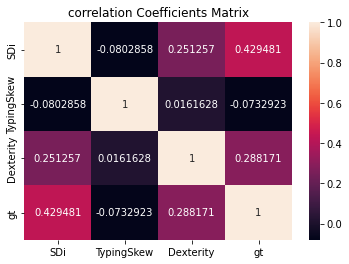

In [490]:
print(len(early_stage))
print(len(de_novo))
early_stage = pd.concat([early_stage,de_novo])
print(len(early_stage))
import seaborn as sns
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
dataframe = early_stage[['SDi','TypingSkew','Dexterity','gt']]
dataframe["gt"] =list(map(lambda x : 1 if x == True else 0 , dataframe["gt"]))
dataframe[['SDi','TypingSkew','Dexterity']] = sc.fit_transform(dataframe.iloc[:,:-1])
corrcoefs = np.corrcoef(dataframe.T, bias=True)
labs = ['SDi', 'TypingSkew', 'Dexterity','gt']
sns.heatmap(corrcoefs, annot=True, fmt='g', xticklabels=labs, yticklabels=labs)
plt.title("correlation Coefficients Matrix")
print(np.shape(corrcoefs))


In [491]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
cat, num = "gt", "TypingSkew"
model = smf.ols(num+' ~ '+cat, data=early_stage).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Non-Correlated (p-value: 0.434)


In [492]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
cat, num = "gt", "htArrOutliers"
model = smf.ols(num+' ~ '+cat, data=early_stage).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.003)


## splitting the data into features and dependant variable and further splitting into train and testing data

In [493]:
early_stage.drop('TypingSkew',axis=1, inplace=True)
early_stage.drop('htArrOutliers',axis=1, inplace=True)
X = early_stage.iloc[:, :-1].values
y = early_stage.iloc[:, -1].values

In [494]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [495]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit_transform(X_train)
sc.transform(X_test)

array([[-0.36567256,  0.03085458],
       [-0.65506966,  0.26027585],
       [ 0.09500652,  0.47903131],
       [ 0.66453597, -0.42780352],
       [ 0.25968971, -0.56279091],
       [-0.63968057, -0.3091873 ],
       [-0.23138539,  1.66342191],
       [-1.41606752, -0.890495  ],
       [ 0.47727132,  1.34179575],
       [ 0.29073059, -0.64597185],
       [-0.45839985, -0.890495  ],
       [ 0.37392344, -0.60251442],
       [ 0.29073059, -0.64597185],
       [-1.46322133, -0.54558856],
       [ 0.73756195, -0.01621783],
       [-0.83624189,  1.48730181],
       [ 0.15886293,  0.4153102 ],
       [-1.10658909, -0.890495  ],
       [-0.67468384, -0.890495  ],
       [ 0.15599845, -0.69571858],
       [-0.22280067,  0.56846813],
       [-0.0600093 ,  0.1531905 ],
       [ 0.09500652,  0.47903131],
       [-1.2314475 , -0.890495  ]])

Confusion matrix, without normalization
[[6 4]
 [7 7]]
Normalized confusion matrix
[[0.6 0.4]
 [0.5 0.5]]


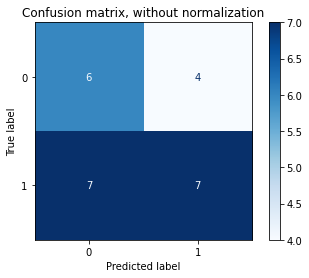

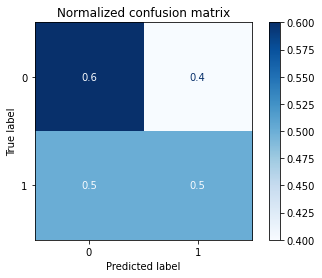

Accuracy score : 0.5416666666666666
Mean accuracy of 30 fold cross validation test : 0.65
with a maximum accuracy of 1.0


In [496]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0)
testClassifier(classifier,X_train,X_test,y_train,y_test)


In [497]:
y_pred =  classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.reshape(len(y_test),1)),1))

[[0 0]
 [0 1]
 [1 1]
 [1 1]
 [1 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [1 0]
 [0 1]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [0 1]
 [1 1]
 [0 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 1]
 [0 0]]


## attempting to use K-neighrest neighbour 

Confusion matrix, without normalization
[[6 4]
 [9 5]]
Normalized confusion matrix
[[0.6        0.4       ]
 [0.64285714 0.35714286]]


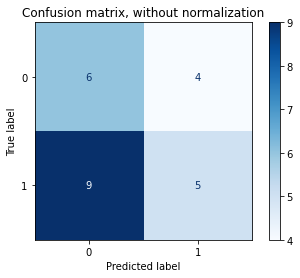

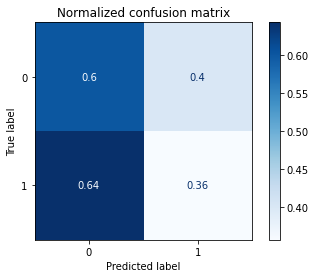

Accuracy score : 0.4583333333333333
Mean accuracy of 30 fold cross validation test : 0.6416666666666667
with a maximum accuracy of 1.0


In [498]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=50)
testClassifier(classifier,X_train,X_test,y_train,y_test)

In [499]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [0 1]
 [0 1]
 [1 1]
 [1 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [1 0]
 [0 1]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [0 1]
 [1 1]
 [0 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]]


Confusion matrix, without normalization
[[6 4]
 [9 5]]
Normalized confusion matrix
[[0.6        0.4       ]
 [0.64285714 0.35714286]]


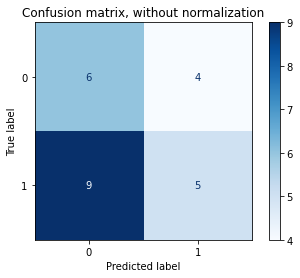

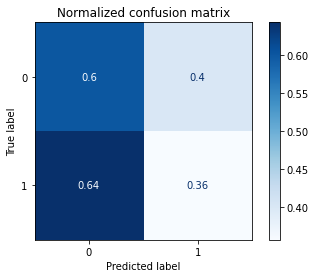

Accuracy score : 0.4583333333333333
Mean accuracy of 30 fold cross validation test : 0.6361111111111112
with a maximum accuracy of 1.0


In [500]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf')
testClassifier(classifier,X_train,X_test,y_train,y_test)

In [501]:
y_pred =  classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.reshape(len(y_test),1)),1))

[[0 0]
 [0 1]
 [0 1]
 [1 1]
 [1 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [1 0]
 [0 1]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [0 1]
 [1 1]
 [0 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]]


In [502]:
# import statsmodels.formula.api as smf
# import statsmodels.api as sm
# cat, num = "gt", "htArrOutliers"
# model = smf.ols(num+' ~ '+cat, data=early_stage).fit()
# table = sm.stats.anova_lm(model)
# p = table["PR(>F)"][0]
# coeff, p = None, round(p, 3)
# conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
# print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Confusion matrix, without normalization
[[9 1]
 [7 7]]
Normalized confusion matrix
[[0.9 0.1]
 [0.5 0.5]]


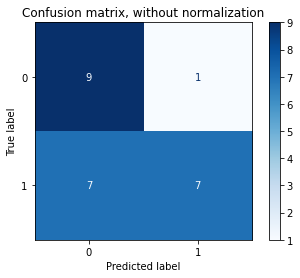

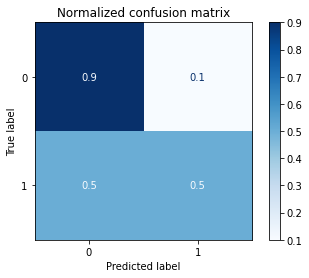

Accuracy score : 0.6666666666666666
Mean accuracy of 30 fold cross validation test : 0.7
with a maximum accuracy of 1.0


In [503]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
svc = SVC()
classifier = BaggingClassifier(base_estimator=nb , n_estimators=10)
testClassifier(classifier,X_train,X_test,y_train,y_test)

In [504]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [0 1]
 [1 1]
 [1 1]
 [0 0]
 [0 1]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [1 1]
 [0 0]]


Confusion matrix, without normalization
[[6 4]
 [5 9]]
Normalized confusion matrix
[[0.6        0.4       ]
 [0.35714286 0.64285714]]


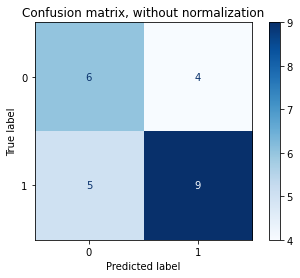

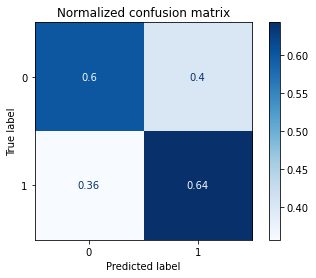

Accuracy score : 0.625
Mean accuracy of 30 fold cross validation test : 0.7194444444444446
with a maximum accuracy of 1.0


In [509]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

classifier = LDA(n_components=1)
testClassifier(classifier,X_train,X_test,y_train,y_test)

In [506]:
de_novo

,SDi,TypingSkew,Dexterity,htArrOutliers,gt
0,0.564521,4.721638,0.012277,0.114139,1
1,0.421491,2.103442,0.001475,0.102949,0
2,0.448163,0.905364,0.002181,0.032978,1
3,0.229087,0.586957,0.000000,0.019914,0
4,0.319824,0.608208,0.000000,0.089441,1
5,0.334962,2.113648,0.012832,0.105827,1
6,0.525508,3.024010,0.024994,0.159828,1
7,0.483731,2.521318,0.003503,0.048406,1
8,0.435598,1.771008,0.033744,0.094274,1
9,0.300051,0.934648,0.018004,0.111182,1
